In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime as datetime
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [17]:
data = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/5 data/data_plus_.csv')

In [18]:
data = data[(data['시군구'] == '강릉시')]

In [19]:
data

,일시,시군구,차량수,평균기온,평균상대습도,강수량,평균풍속,최다풍향,SO2,CO,...,전력량,PM10,PM10-1d,서풍계열,계절_숫자,계절_가을,계절_겨울,계절_봄,계절_여름,연도
0,2011-01-01,강릉시,89310,-1.5,71.4,6.0,3.2,320,0.006083,0.458333,...,169825,25.500000,35.541667,1,4,False,True,False,False,2011
1,2011-01-02,강릉시,89310,0.6,66.4,0.5,1.9,270,0.006625,0.454167,...,169825,20.708333,25.500000,3,4,False,True,False,False,2011
2,2011-01-03,강릉시,89310,-0.9,83.6,6.5,2.1,270,0.005750,0.487500,...,169825,20.916667,20.708333,3,4,False,True,False,False,2011
3,2011-01-04,강릉시,89310,-0.1,47.1,0.0,3.7,250,0.005667,0.533333,...,169825,36.666667,20.916667,3,4,False,True,False,False,2011
4,2011-01-05,강릉시,89310,-0.6,46.5,0.0,4.7,250,0.006048,0.504762,...,169825,50.333333,36.666667,3,4,False,True,False,False,2011
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3180,2019-12-27,강릉시,109166,2.5,38.8,0.0,3.1,230,0.002333,0.462500,...,175343812,24.708333,29.083333,2,4,False,True,False,False,2019
3181,2019-12-28,강릉시,109166,3.7,45.4,0.0,2.0,230,0.002875,0.516667,...,175343812,35.208333,24.708333,2,4,False,True,False,False,2019
3182,2019-12-29,강릉시,109166,6.7,48.1,0.0,2.0,250,0.002583,0.495833,...,175343812,34.166667,35.208333,3,4,False,True,False,False,2019
3183,2019-12-30,강릉시,109166,8.3,57.9,0.0,3.3,230,0.002208,0.429167,...,175343812,18.750000,34.166667,2,4,False,True,False,False,2019


In [20]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.layers import LSTM, Dense, Dropout, LeakyReLU
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

In [21]:
# 특성과 타겟 설정
features = ['평균기온', '평균상대습도', '강수량', '평균풍속', '최다풍향', 'SO2',
            'CO', 'O3', 'NO2', 'PM10-1d', '서풍계열', '계절_가을', '계절_겨울', '계절_봄', '계절_여름']
target = 'PM10'

# '일시' 열을 datetime 형식으로 변환
data['일시'] = pd.to_datetime(data['일시'])

# 연도 정보 추출
data['연도'] = data['일시'].dt.year

# Train/Test 데이터 분리 (2011-2017년: Train, 2018-2019년: Test)
train_data = data[data['연도'].between(2011, 2017)]
test_data = data[data['연도'].between(2018, 2019)]

# Feature와 Target 분리
X_train = train_data[features].values  # DataFrame -> NumPy 배열 LSTM에선 NumPy 배열이어야 함
y_train = train_data[target].values
X_test = test_data[features].values
y_test = test_data[target].values

# 데이터 정규화
scaler_X_lstm = MinMaxScaler()
scaler_y_lstm = MinMaxScaler()
X_train = scaler_X_lstm.fit_transform(X_train)
X_test = scaler_X_lstm.transform(X_test)
y_train = scaler_y_lstm.fit_transform(y_train.reshape(-1, 1))
y_test = scaler_y_lstm.transform(y_test.reshape(-1, 1))

# LSTM 입력 형태로 변환 (samples, timesteps, features)
X_train_lstm = X_train.reshape((X_train.shape[0], 1, X_train.shape[1]))
X_test_lstm = X_test.reshape((X_test.shape[0], 1, X_test.shape[1]))


In [25]:
# 이상치 제거
# Define a function to handle outliers using the IQR method
def remove_outliers(data, column):
    Q1 = data[column].quantile(0.25)
    Q3 = data[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return data[(data[column] >= lower_bound) & (data[column] <= upper_bound)]

# Apply outlier removal to key features
columns_with_outliers = ['PM10', '강수량', 'SO2', 'CO', 'O3', 'NO2']
cleaned_data = data.copy()

for column in columns_with_outliers:
    cleaned_data = remove_outliers(cleaned_data, column)

# Display the shape of the dataset before and after cleaning
original_shape = data.shape
cleaned_shape = cleaned_data.shape

print(f"Original Shape: {original_shape}")
print(f"Cleaned Shape: {cleaned_shape}")


Original Shape: (3185, 23)
Cleaned Shape: (2096, 23)


In [32]:
# LSTM 128 64 64 64
model = Sequential([
    LSTM(64, activation='relu', return_sequences=True, input_shape=(X_train_lstm.shape[1], X_train_lstm.shape[2])),
    Dropout(0.2),
    LSTM(64, activation='relu', return_sequences=False),
    Dropout(0.2),
    Dense(32, activation='relu'),
    Dense(1)  # 출력층
])

# 모델 컴파일
model.compile(optimizer='adam', loss='mean_squared_error')

# 모델 학습
history = model.fit(X_train_lstm, y_train, epochs=50, batch_size=32, validation_data=(X_test_lstm, y_test), verbose=1)

# 모델 평가
loss = model.evaluate(X_test_lstm, y_test, verbose=1)
print(f'Test Loss: {loss}')

# 예측
y_pred = model.predict(X_test_lstm)

# 역정규화
y_test_inv = scaler_y_lstm.inverse_transform(y_test)
y_pred_inv = scaler_y_lstm.inverse_transform(y_pred)

# 성능 지표 계산
rmse = np.sqrt(mean_squared_error(y_test_inv, y_pred_inv))
r2 = r2_score(y_test_inv, y_pred_inv)

print(f"RMSE: {rmse}")
print(f"R² Score: {r2}")


Epoch 1/50


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


80/80 ━━━━━━━━━━━━━━━━━━━━ 6s 12ms/step - loss: 0.0090 - val_loss: 0.0024
Epoch 2/50
80/80 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0033 - val_loss: 0.0023
Epoch 3/50
80/80 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0026 - val_loss: 0.0019
Epoch 4/50
80/80 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0024 - val_loss: 0.0019
Epoch 5/50
80/80 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - loss: 0.0023 - val_loss: 0.0022
Epoch 6/50
80/80 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.0022 - val_loss: 0.0017
Epoch 7/50
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0018 - val_loss: 0.0016
Epoch 8/50
80/80 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0019 - val_loss: 0.0016
Epoch 9/50
80/80 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0020 - val_loss: 0.0017
Epoch 10/50
80/80 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0019 - val_loss: 0.0017
Epoch 11/50
80/80 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0019 - val_loss: 0.0016
Epoch 12/50
80/80 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0014 - val_loss: 0.00

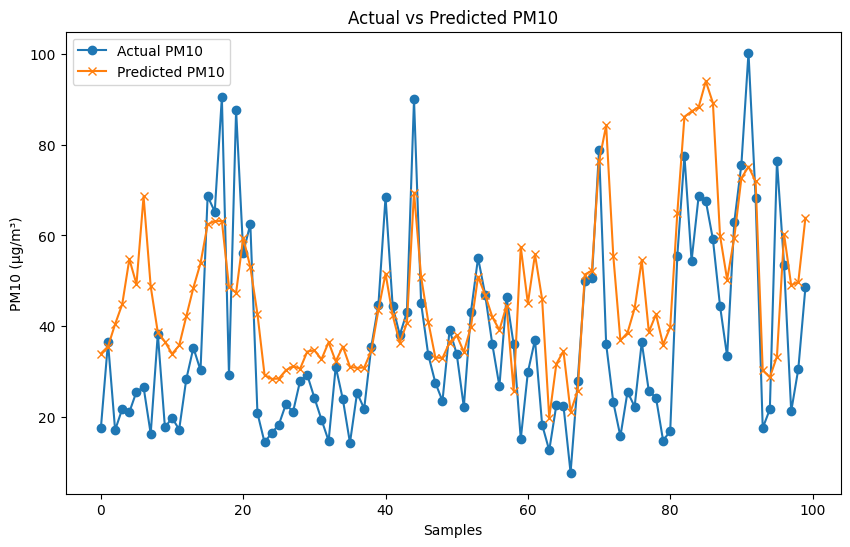

In [33]:
# 시각화 실제 값과 예측값 비교
plt.figure(figsize=(10, 6))
plt.plot(y_test_inv[:100], label="Actual PM10", marker='o')
plt.plot(y_pred_inv[:100], label="Predicted PM10", marker='x')
plt.title("Actual vs Predicted PM10")
plt.xlabel("Samples")
plt.ylabel("PM10 (µg/m³)")
plt.legend()
plt.show()

In [28]:
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import MinMaxScaler
import numpy as np


In [29]:
from sklearn.model_selection import GridSearchCV

# 하이퍼파라미터 그리드 설정
param_grid = {
    'n_estimators': [50, 100, 200],  # 트리 개수
    'max_depth': [10, 20, 30],  # 최대 깊이
}

# 랜덤포레스트 모델 정의
rf_model = RandomForestRegressor(random_state=42)

# GridSearchCV 정의
grid_search = GridSearchCV(estimator=rf_model, param_grid=param_grid, cv=3, scoring='neg_mean_squared_error', verbose=2, n_jobs=-1)

# GridSearch 실행
grid_search.fit(X_train, y_train)

# 최적의 하이퍼파라미터 출력
print("Best Parameters:", grid_search.best_params_)

# 최적 모델 가져오기
best_rf_model = grid_search.best_estimator_

# Test 데이터에 대한 예측
y_pred_best_rf = best_rf_model.predict(X_test)

# 평가 지표 계산
rmse = np.sqrt(mean_squared_error(y_test, y_pred_best_rf))
r2 = r2_score(y_test, y_pred_best_rf)

print(f"Optimized Random Forest RMSE: {rmse}")
print(f"Optimized Random Forest R² Score: {r2}")


Fitting 3 folds for each of 9 candidates, totalling 27 fits


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Best Parameters: {'max_depth': 20, 'n_estimators': 200}
Optimized Random Forest RMSE: 0.03618507185934824
Optimized Random Forest R² Score: 0.5076040681322846


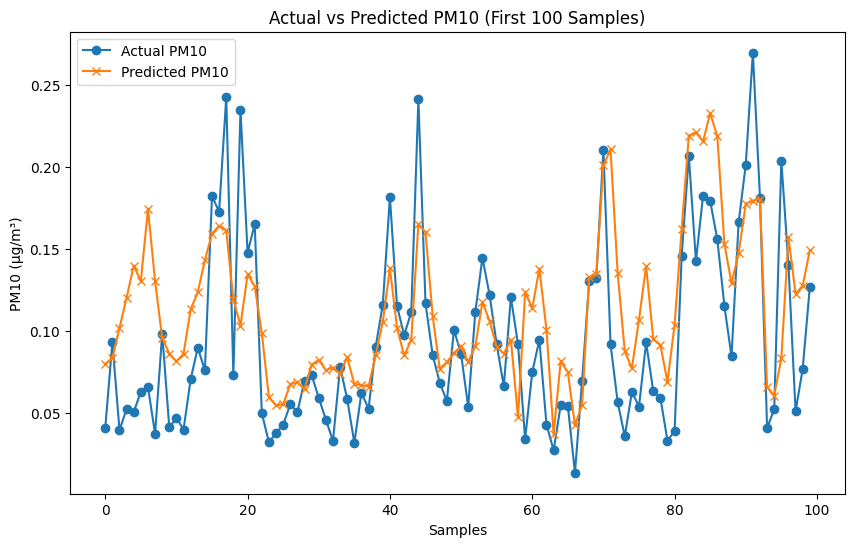

In [31]:
import matplotlib.pyplot as plt

# 예측 결과 시각화
plt.figure(figsize=(10, 6))
plt.plot(y_test[:100], label="Actual PM10", marker='o')  # 실제 값
plt.plot(y_pred[:100], label="Predicted PM10", marker='x')  # 예측 값
plt.title("Actual vs Predicted PM10 (First 100 Samples)")
plt.xlabel("Samples")
plt.ylabel("PM10 (µg/m³)")
plt.legend()
plt.show()


In [34]:
data

,일시,시군구,차량수,평균기온,평균상대습도,강수량,평균풍속,최다풍향,SO2,CO,...,전력량,PM10,PM10-1d,서풍계열,계절_숫자,계절_가을,계절_겨울,계절_봄,계절_여름,연도
0,2011-01-01,강릉시,89310,-1.5,71.4,6.0,3.2,320,0.006083,0.458333,...,169825,25.500000,35.541667,1,4,False,True,False,False,2011
1,2011-01-02,강릉시,89310,0.6,66.4,0.5,1.9,270,0.006625,0.454167,...,169825,20.708333,25.500000,3,4,False,True,False,False,2011
2,2011-01-03,강릉시,89310,-0.9,83.6,6.5,2.1,270,0.005750,0.487500,...,169825,20.916667,20.708333,3,4,False,True,False,False,2011
3,2011-01-04,강릉시,89310,-0.1,47.1,0.0,3.7,250,0.005667,0.533333,...,169825,36.666667,20.916667,3,4,False,True,False,False,2011
4,2011-01-05,강릉시,89310,-0.6,46.5,0.0,4.7,250,0.006048,0.504762,...,169825,50.333333,36.666667,3,4,False,True,False,False,2011
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3180,2019-12-27,강릉시,109166,2.5,38.8,0.0,3.1,230,0.002333,0.462500,...,175343812,24.708333,29.083333,2,4,False,True,False,False,2019
3181,2019-12-28,강릉시,109166,3.7,45.4,0.0,2.0,230,0.002875,0.516667,...,175343812,35.208333,24.708333,2,4,False,True,False,False,2019
3182,2019-12-29,강릉시,109166,6.7,48.1,0.0,2.0,250,0.002583,0.495833,...,175343812,34.166667,35.208333,3,4,False,True,False,False,2019
3183,2019-12-30,강릉시,109166,8.3,57.9,0.0,3.3,230,0.002208,0.429167,...,175343812,18.750000,34.166667,2,4,False,True,False,False,2019
